# NMI & ARI Test Routine

## Compute Descriptors

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import SpectralClustering
from experiment_utils import compute_knn, plot_evaluation, compute_descriptors_from_file
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics.pairwise import rbf_kernel

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
file = "proteins"
df = compute_descriptors_from_file(file)

## Run Test Routine

In [3]:
knn_types = ['symmetric', 'mutual']
descriptors = [
    ['evrap', 'samp_3d', 'sirm_3d', 'scomp_3d'], ['pfh'], ['sector_model'], ['combined_model'],
    ['shell_model'], ['evrap'], ['samp_3d'], ['sirm_3d'], ['scomp_3d']
]

def load_or_compute_data(mode, n_neighbors):
    pickle_file = f"test_output/{file}_{n_neighbors}_{mode}_nmi_ari.pkl"
    if os.path.isfile(pickle_file):
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
    else:
        data = {
            metric_type: {
                metric: {'_'.join(descriptor): [] for descriptor in descriptors}
                for metric in ['nmi', 'ari']
            }
            for metric_type in knn_types
        }
        data['cluster_size'] = []
    
        cluster_size = range(2, 21)
        for c in cluster_size:
            data['cluster_size'].append(c)
            for variant in knn_types:
                for descriptor in descriptors:
                    knn_graph = compute_knn(df, descriptor_list=descriptor, n_neighbors=n_neighbors, variant=variant,
                                            mode=mode)
    
                    if mode == 'distance':
                        # for numerical stability
                        knn_graph += 1e-10
                        knn_graph = knn_graph / np.max(knn_graph)
                        sigma = 1.0
                        knn_graph = rbf_kernel(knn_graph, gamma=1 / (2 * sigma ** 2))
    
                    spectral = SpectralClustering(
                        n_clusters=c,
                        affinity='precomputed',
                        random_state=42,
                        n_jobs=-1
                    )
                    predicted_labels = spectral.fit_predict(knn_graph)
                    nmi = normalized_mutual_info_score(df["labels"], predicted_labels)
                    ari = adjusted_rand_score(df["labels"], predicted_labels)

                    data[variant]['nmi']['_'.join(descriptor)].append(nmi)
                    data[variant]['ari']['_'.join(descriptor)].append(ari)
        with open(pickle_file, 'wb') as f:
            pickle.dump(data, f)
            
    return data

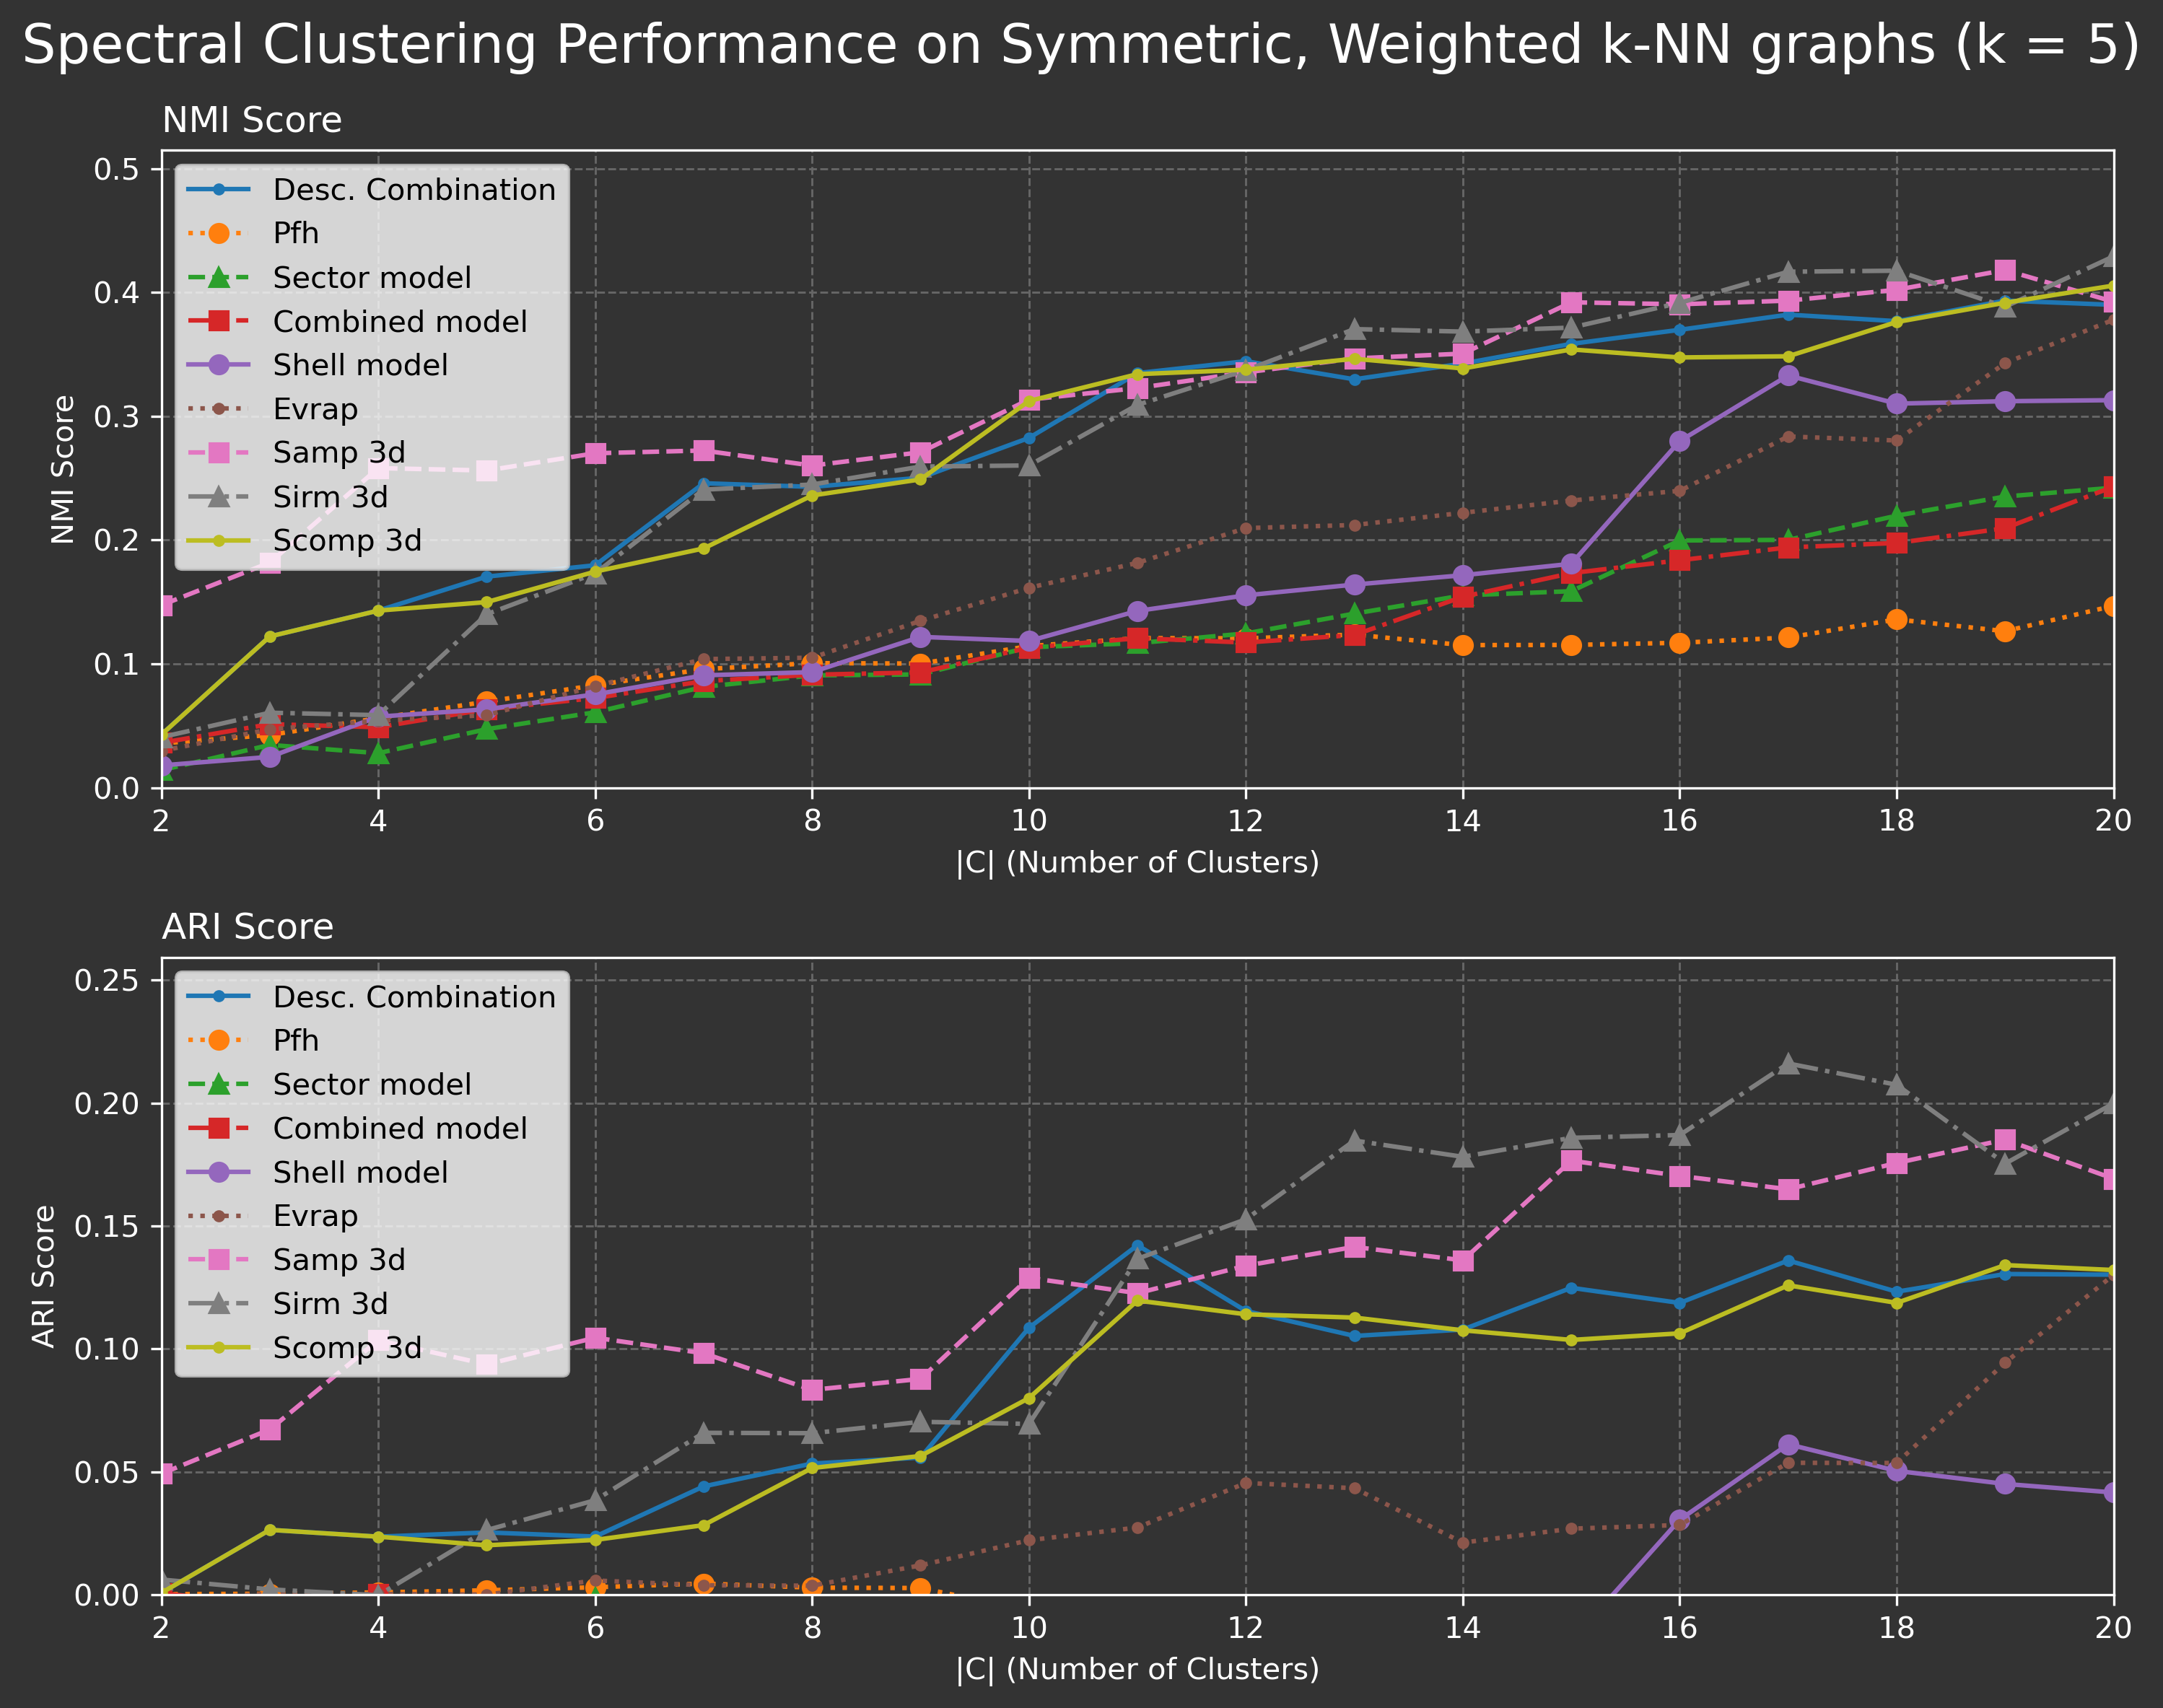

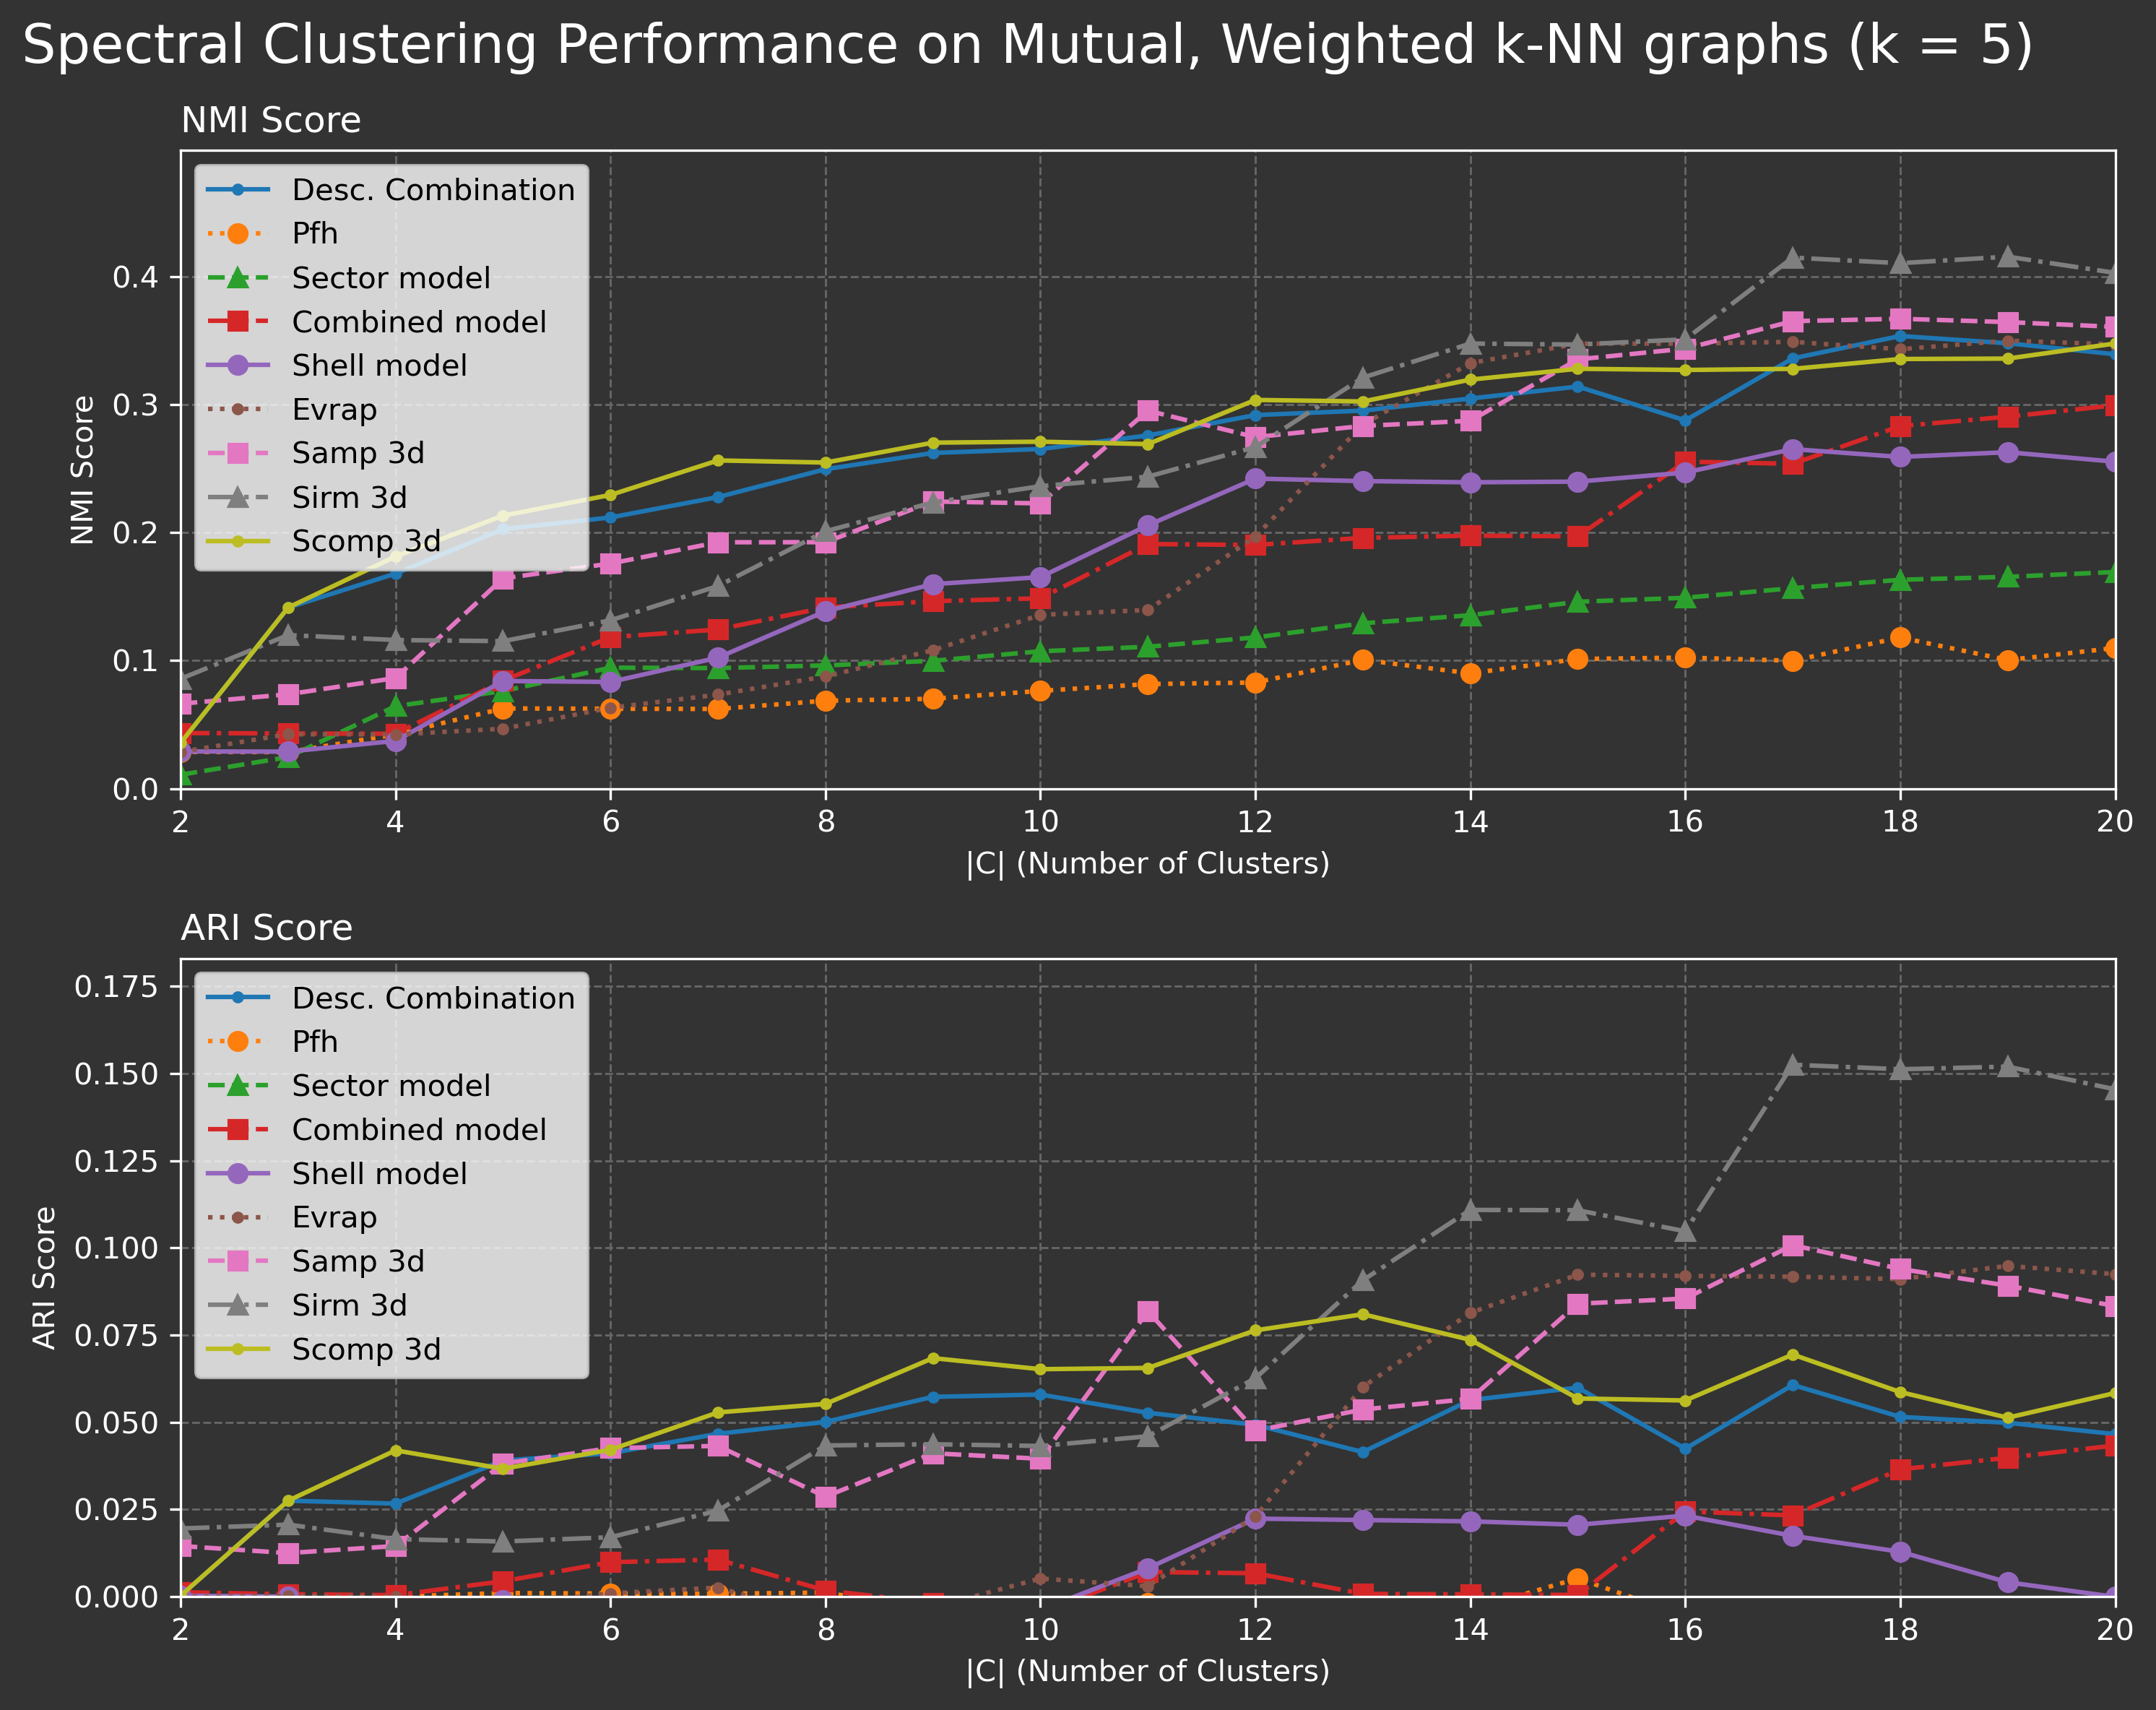

/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarnin

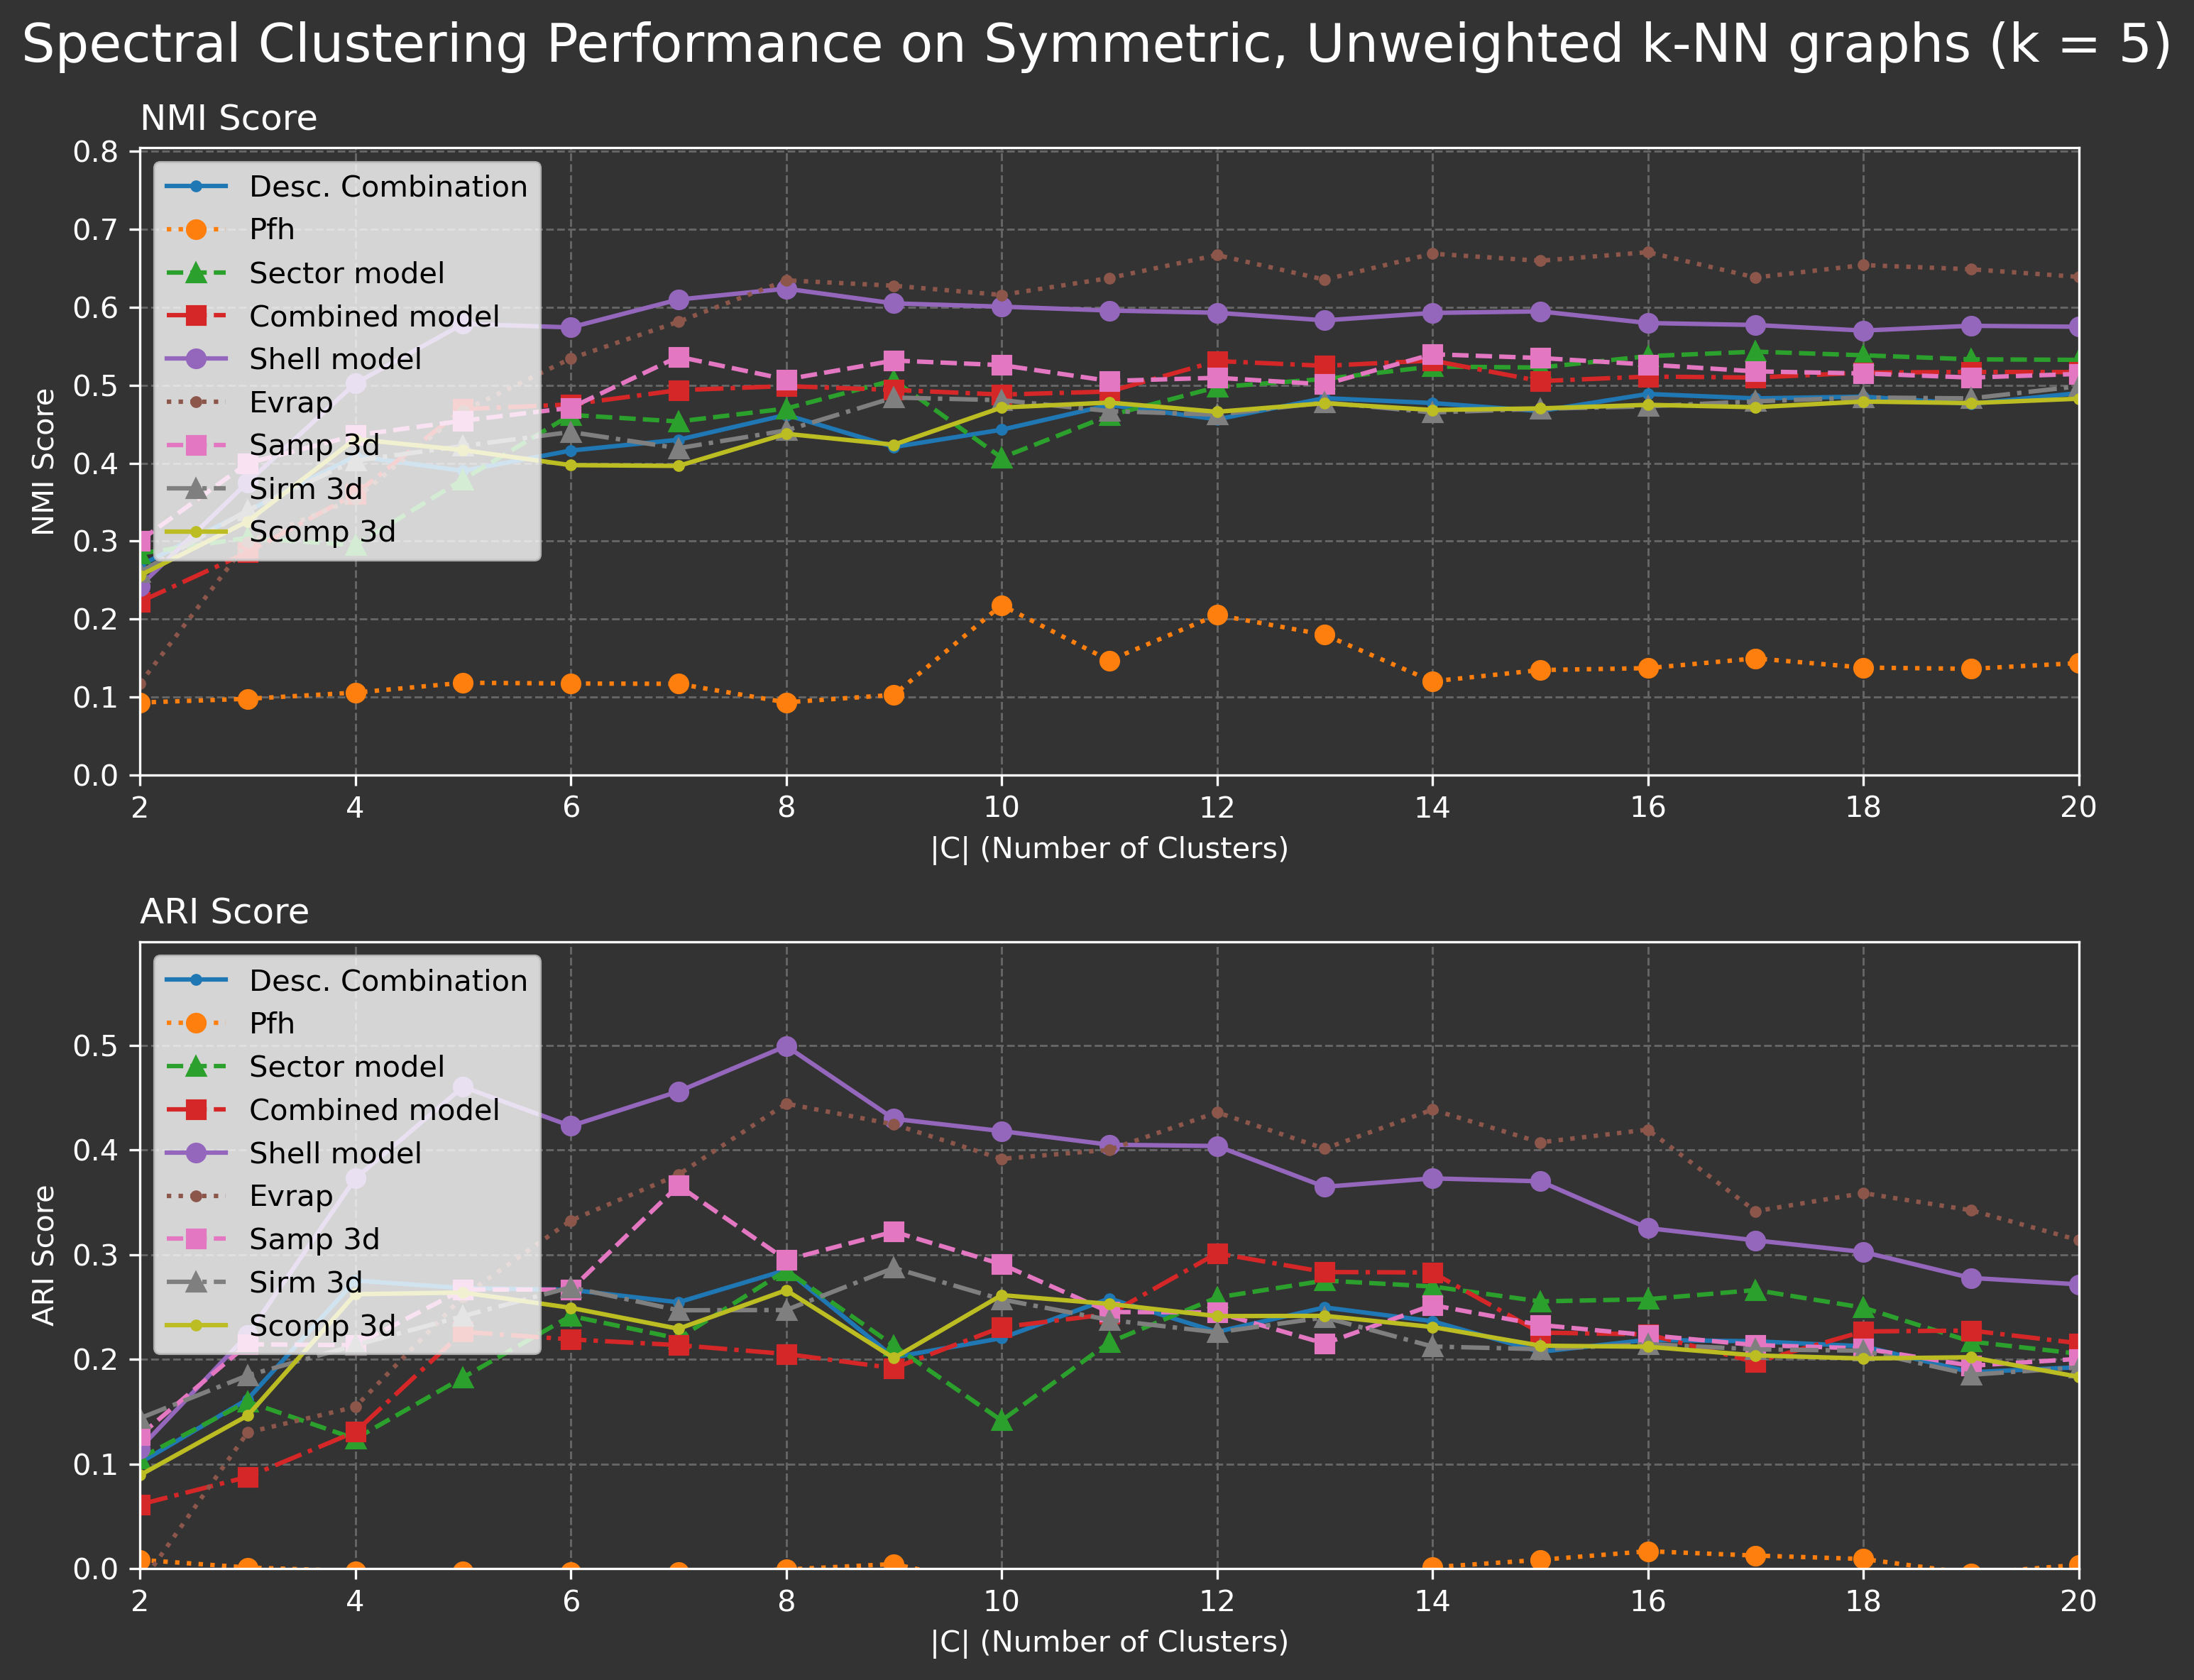

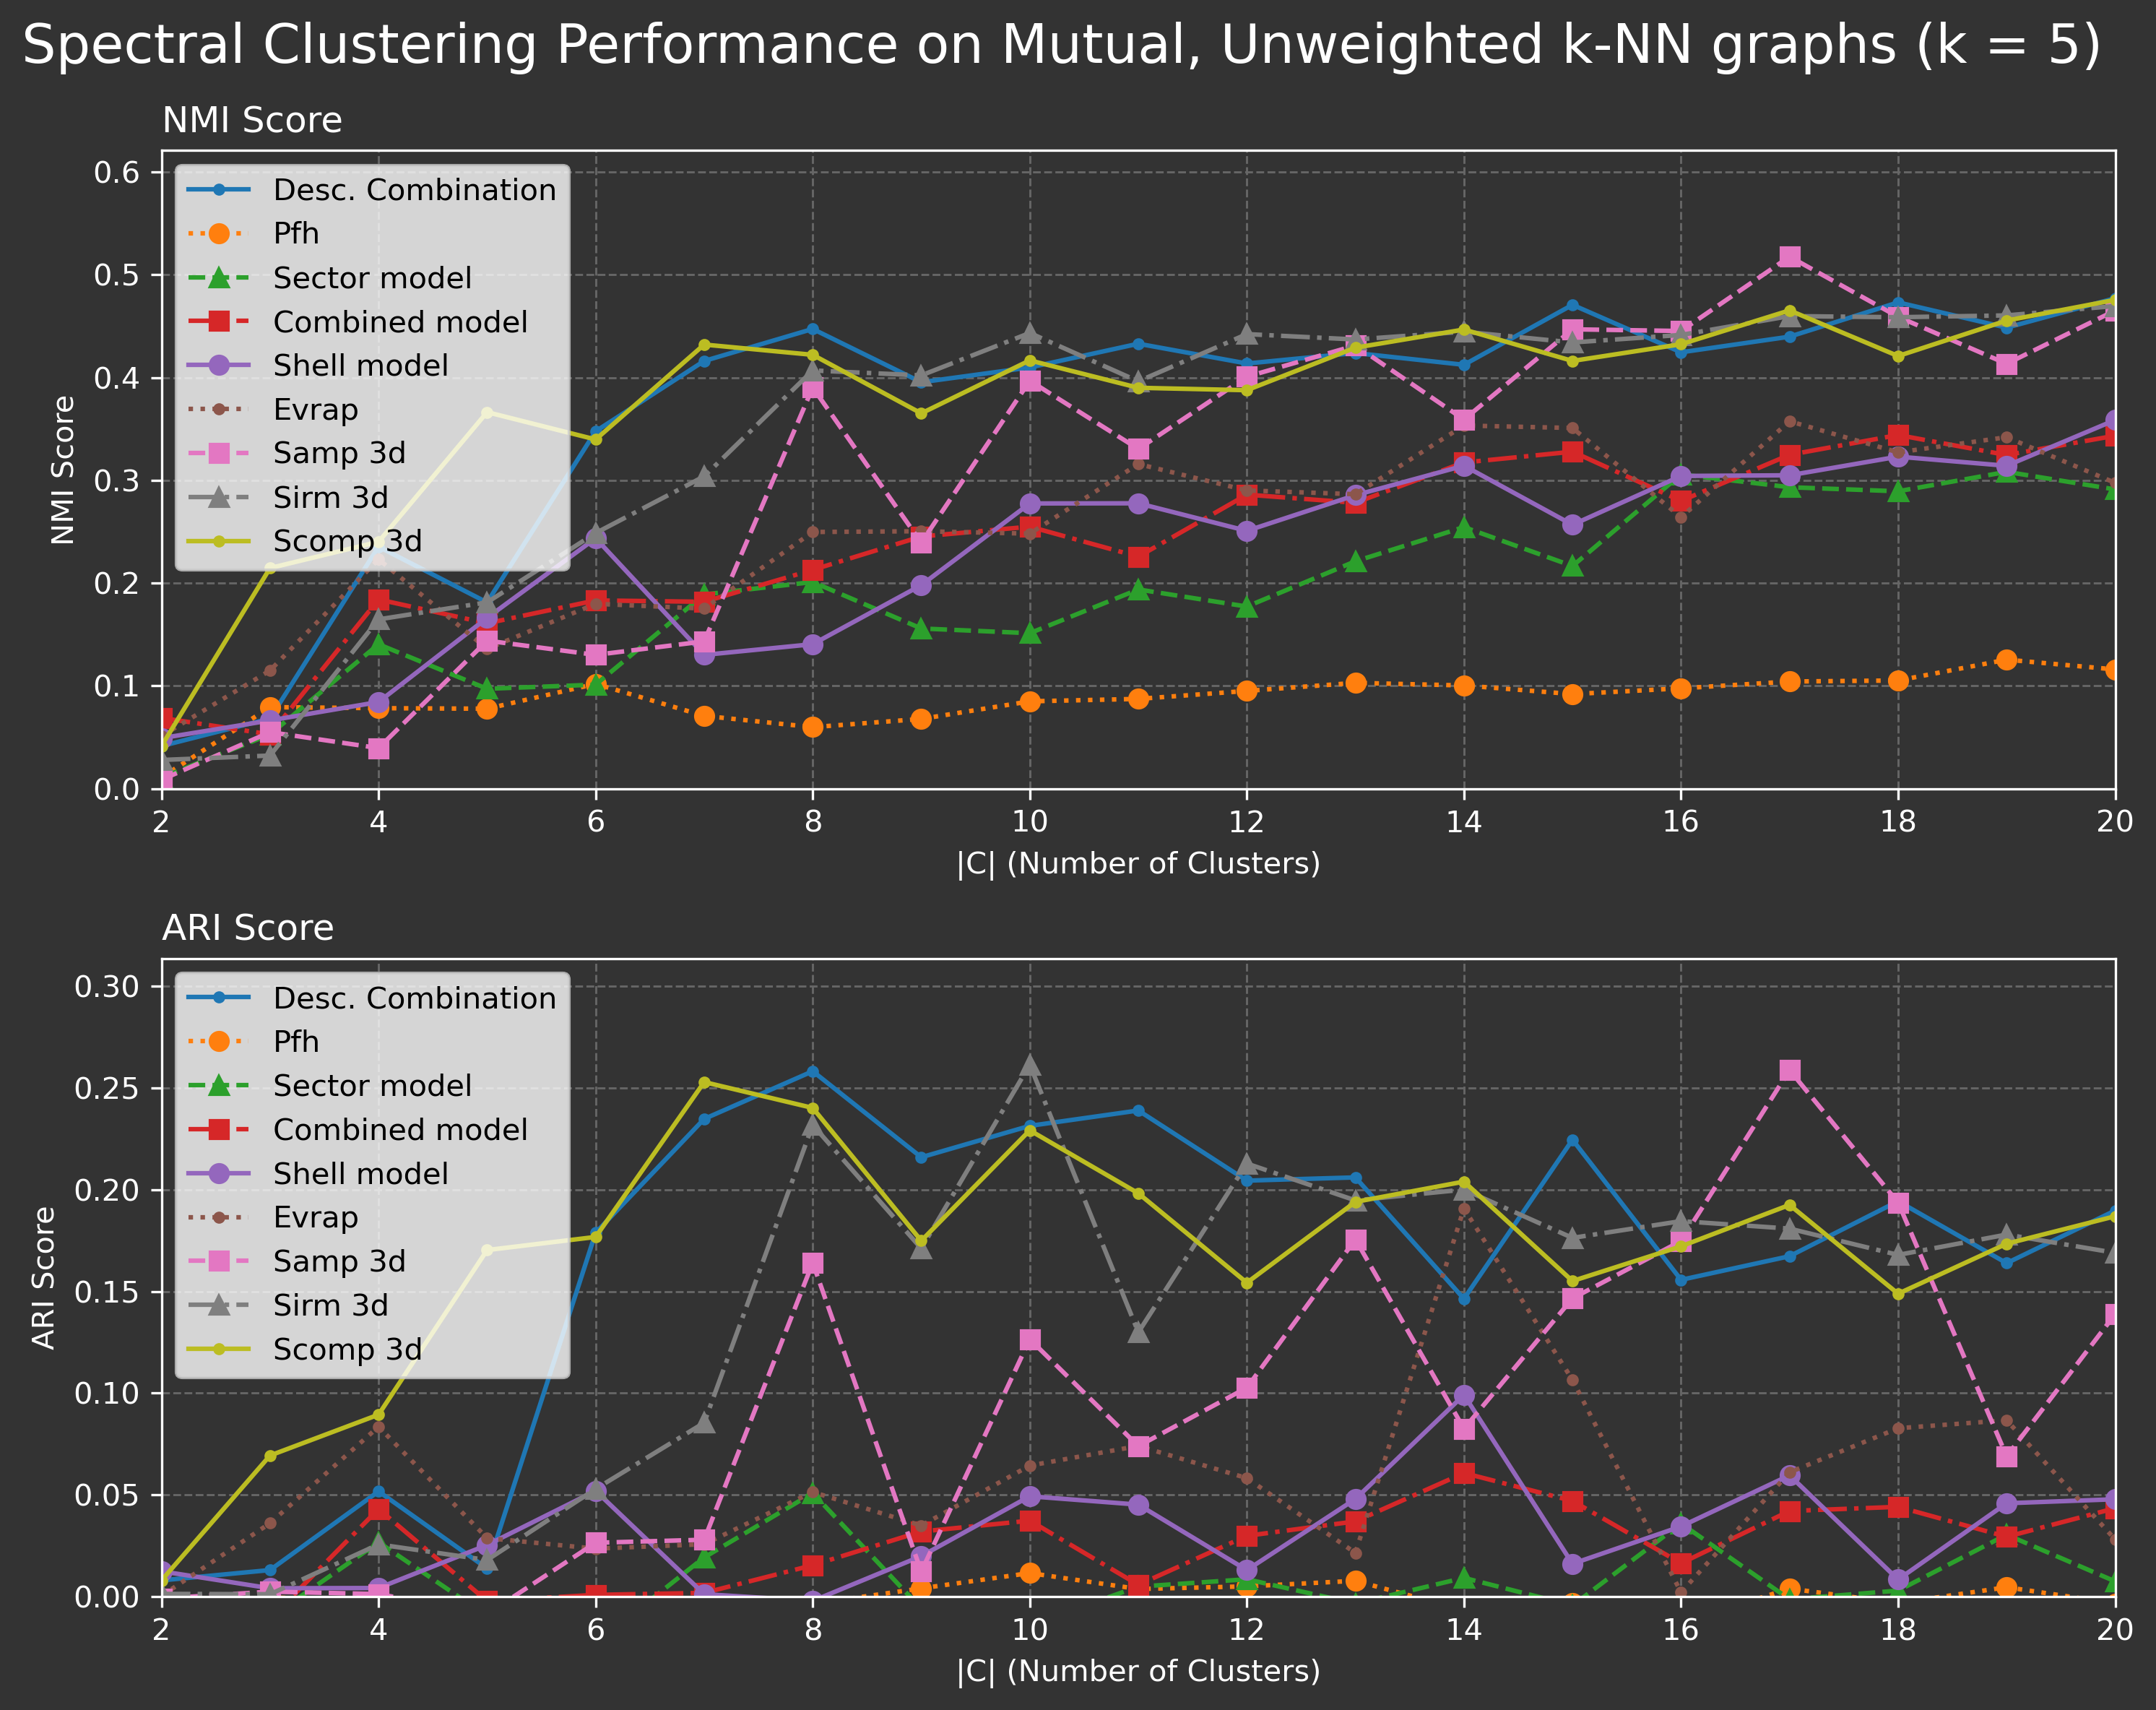

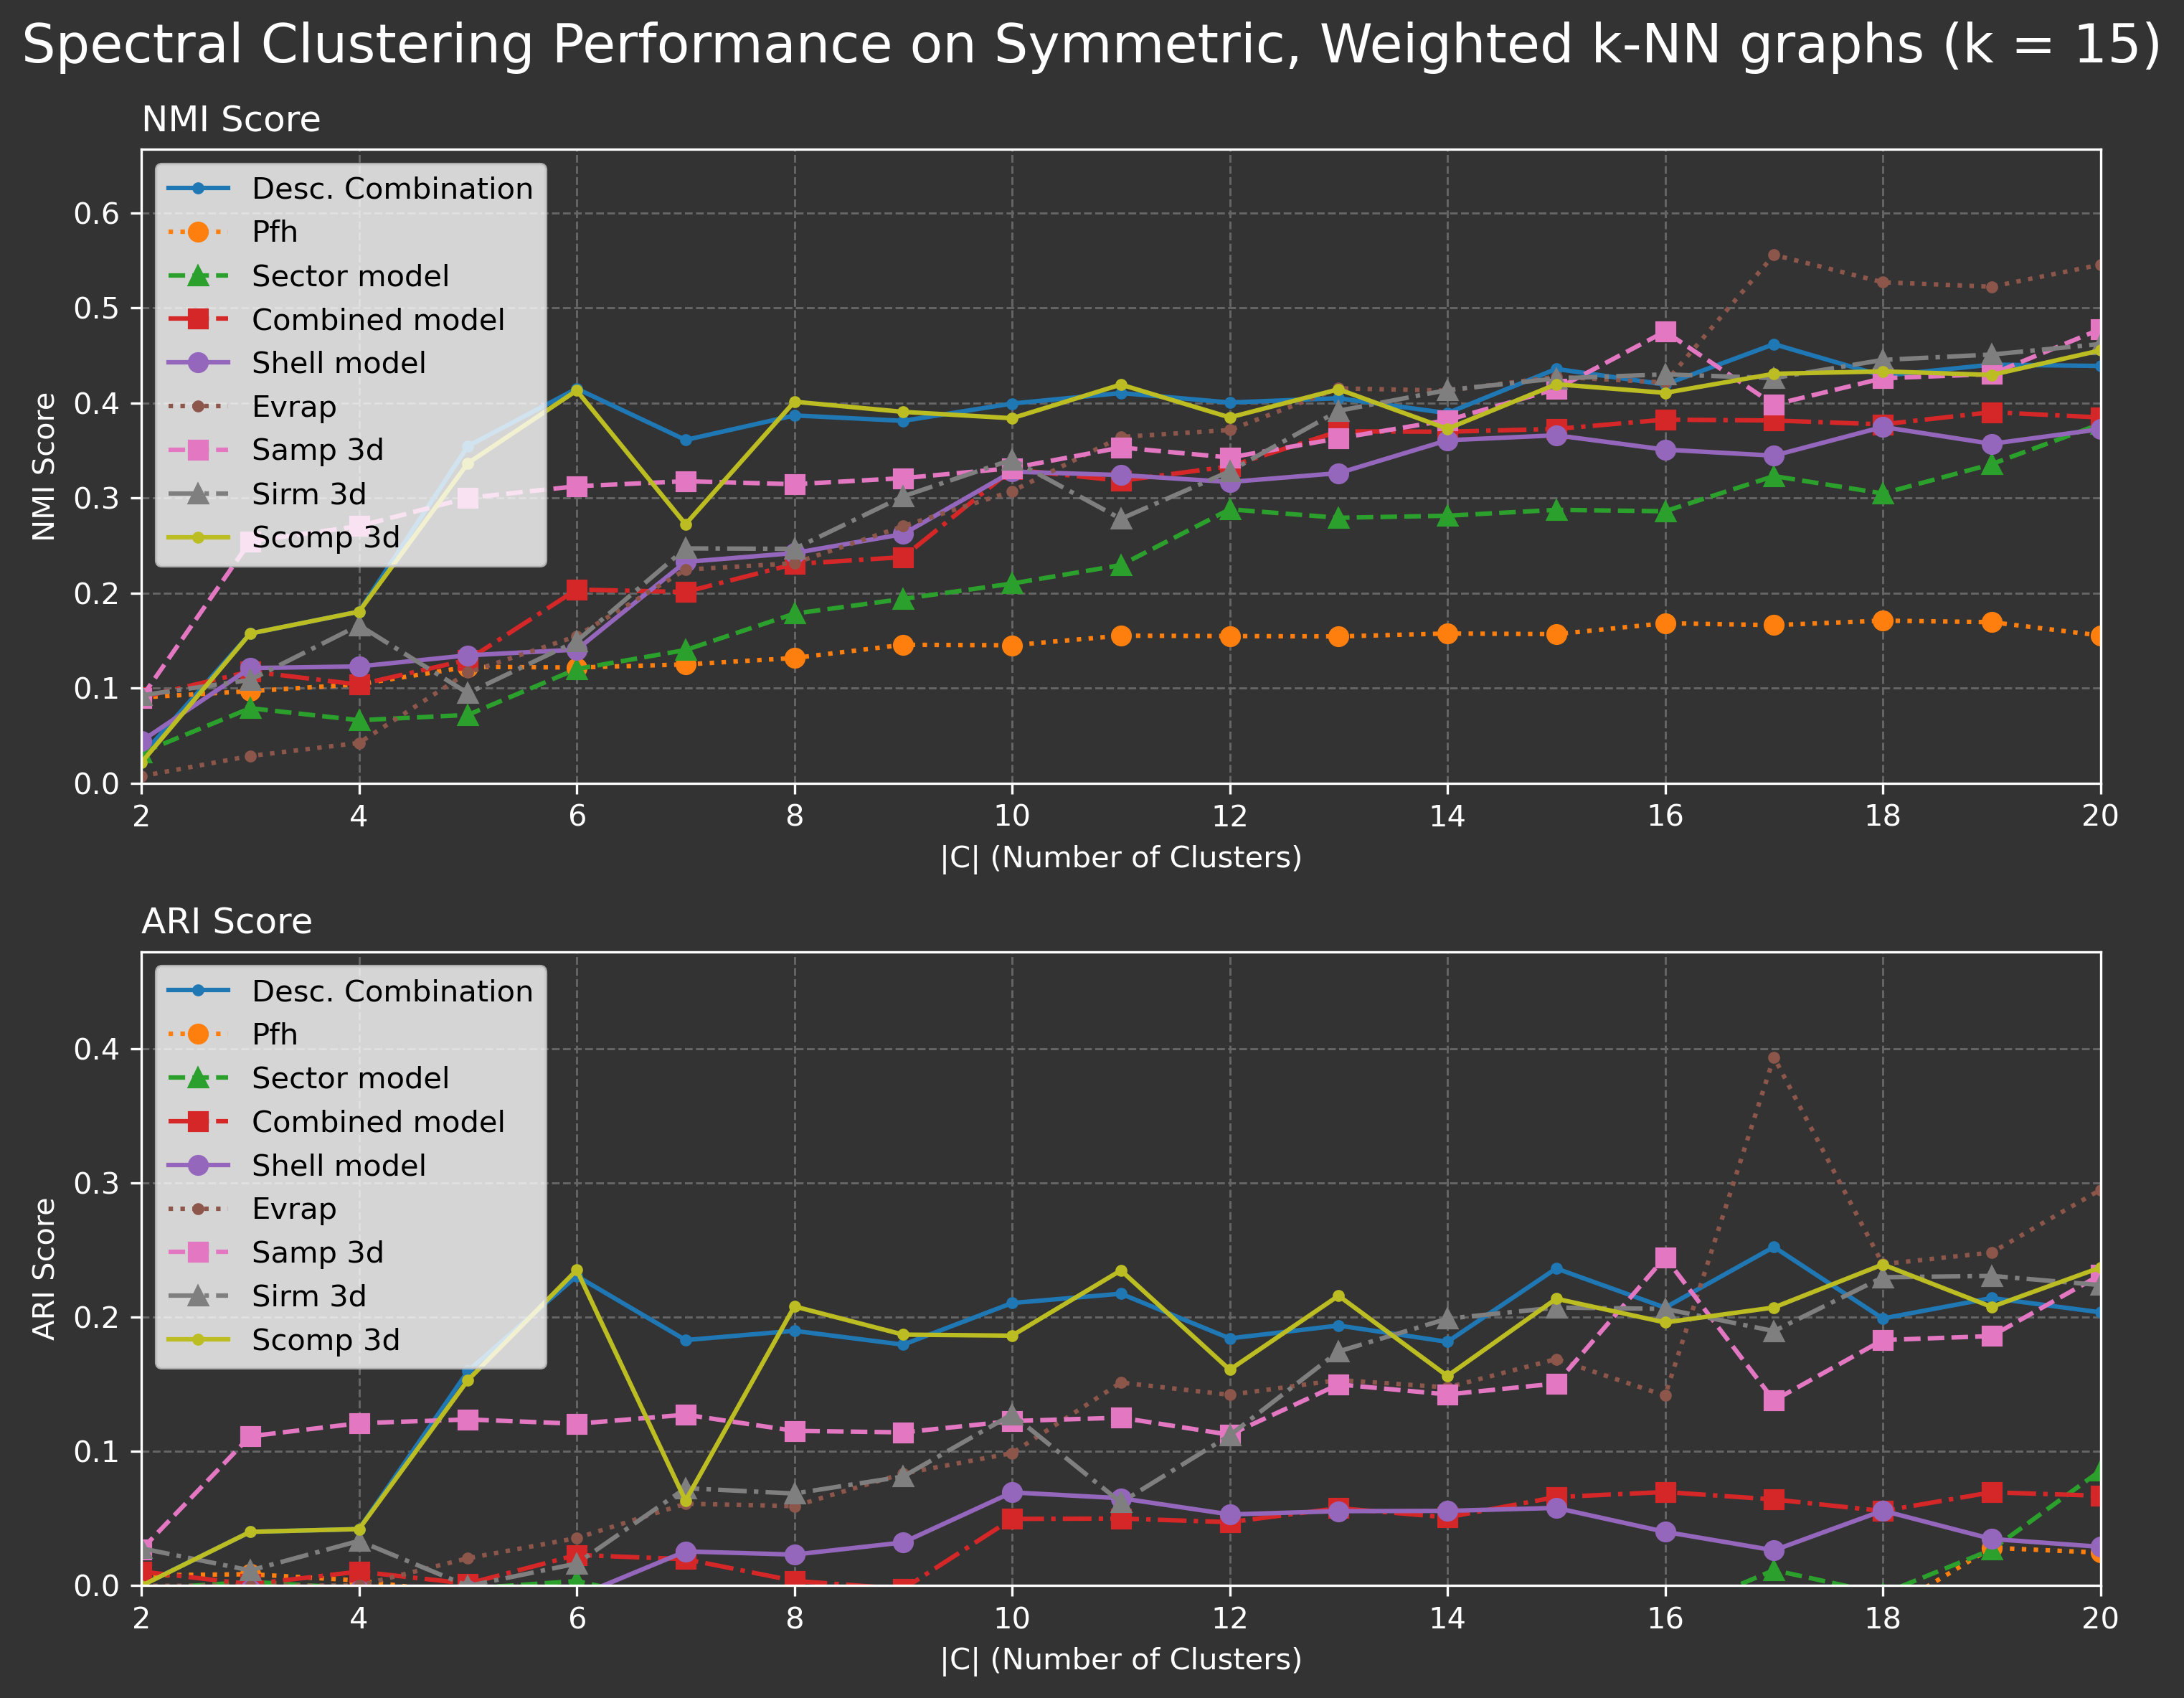

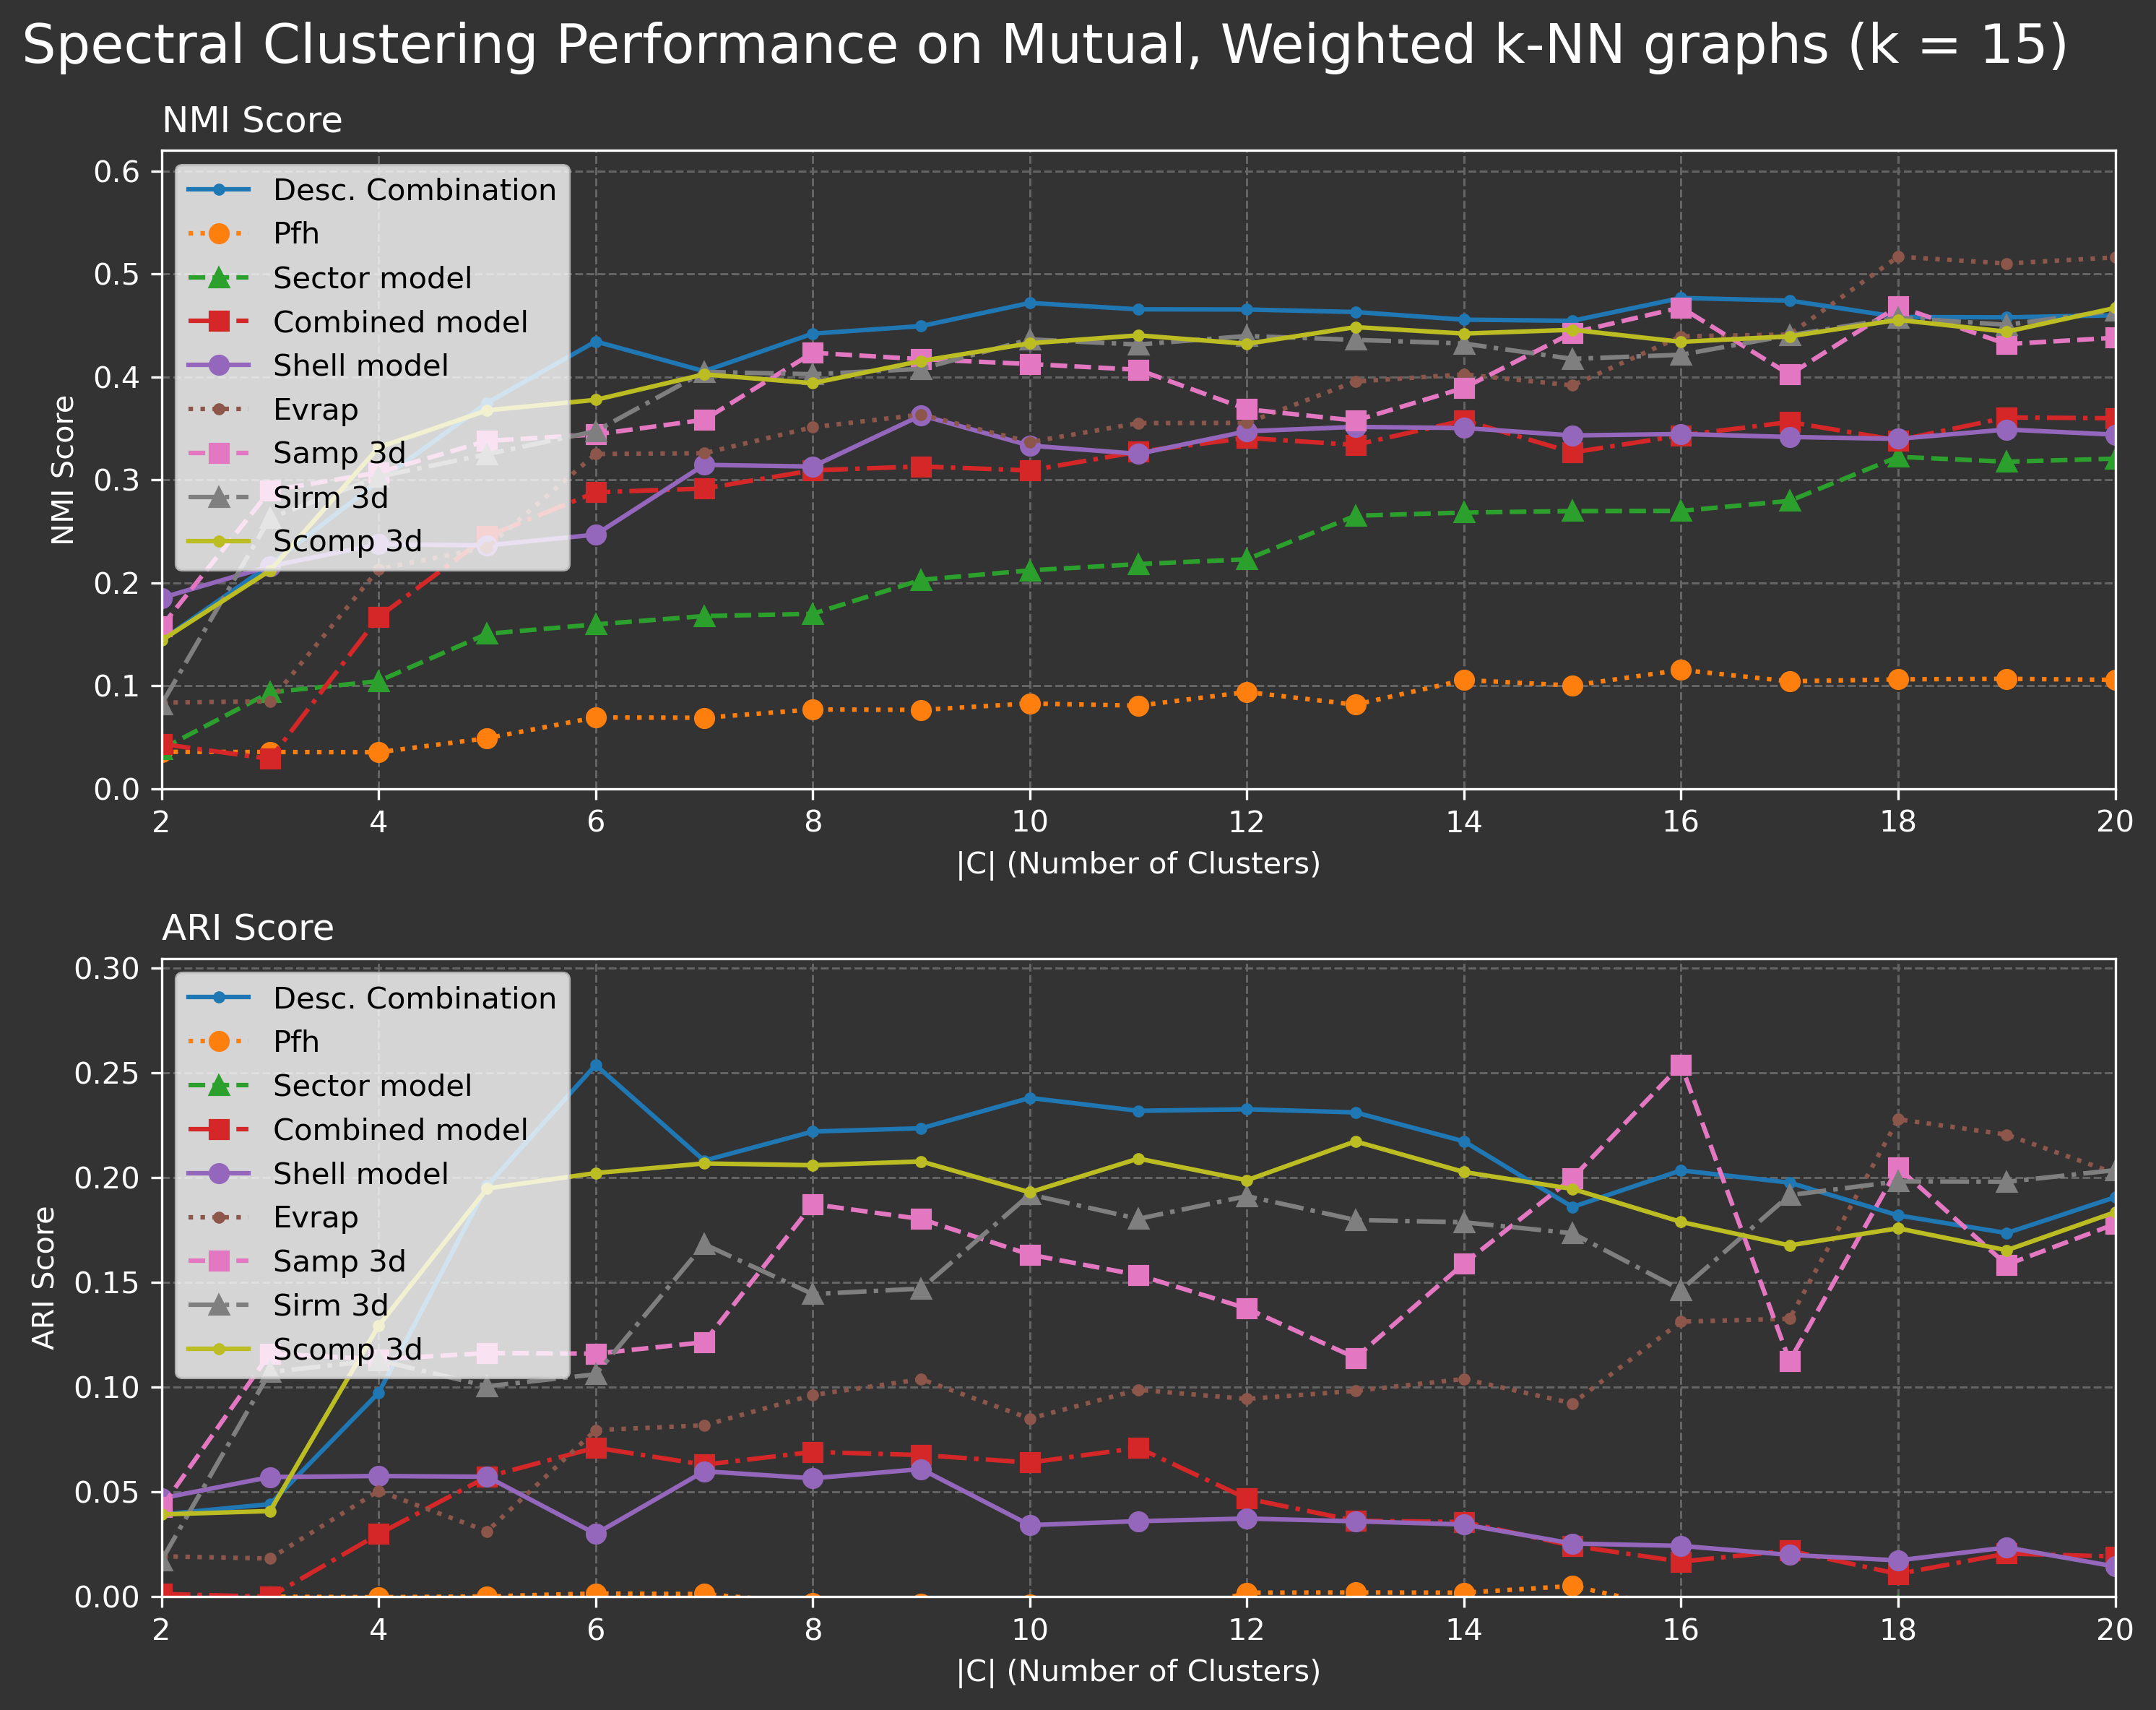

/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarnin

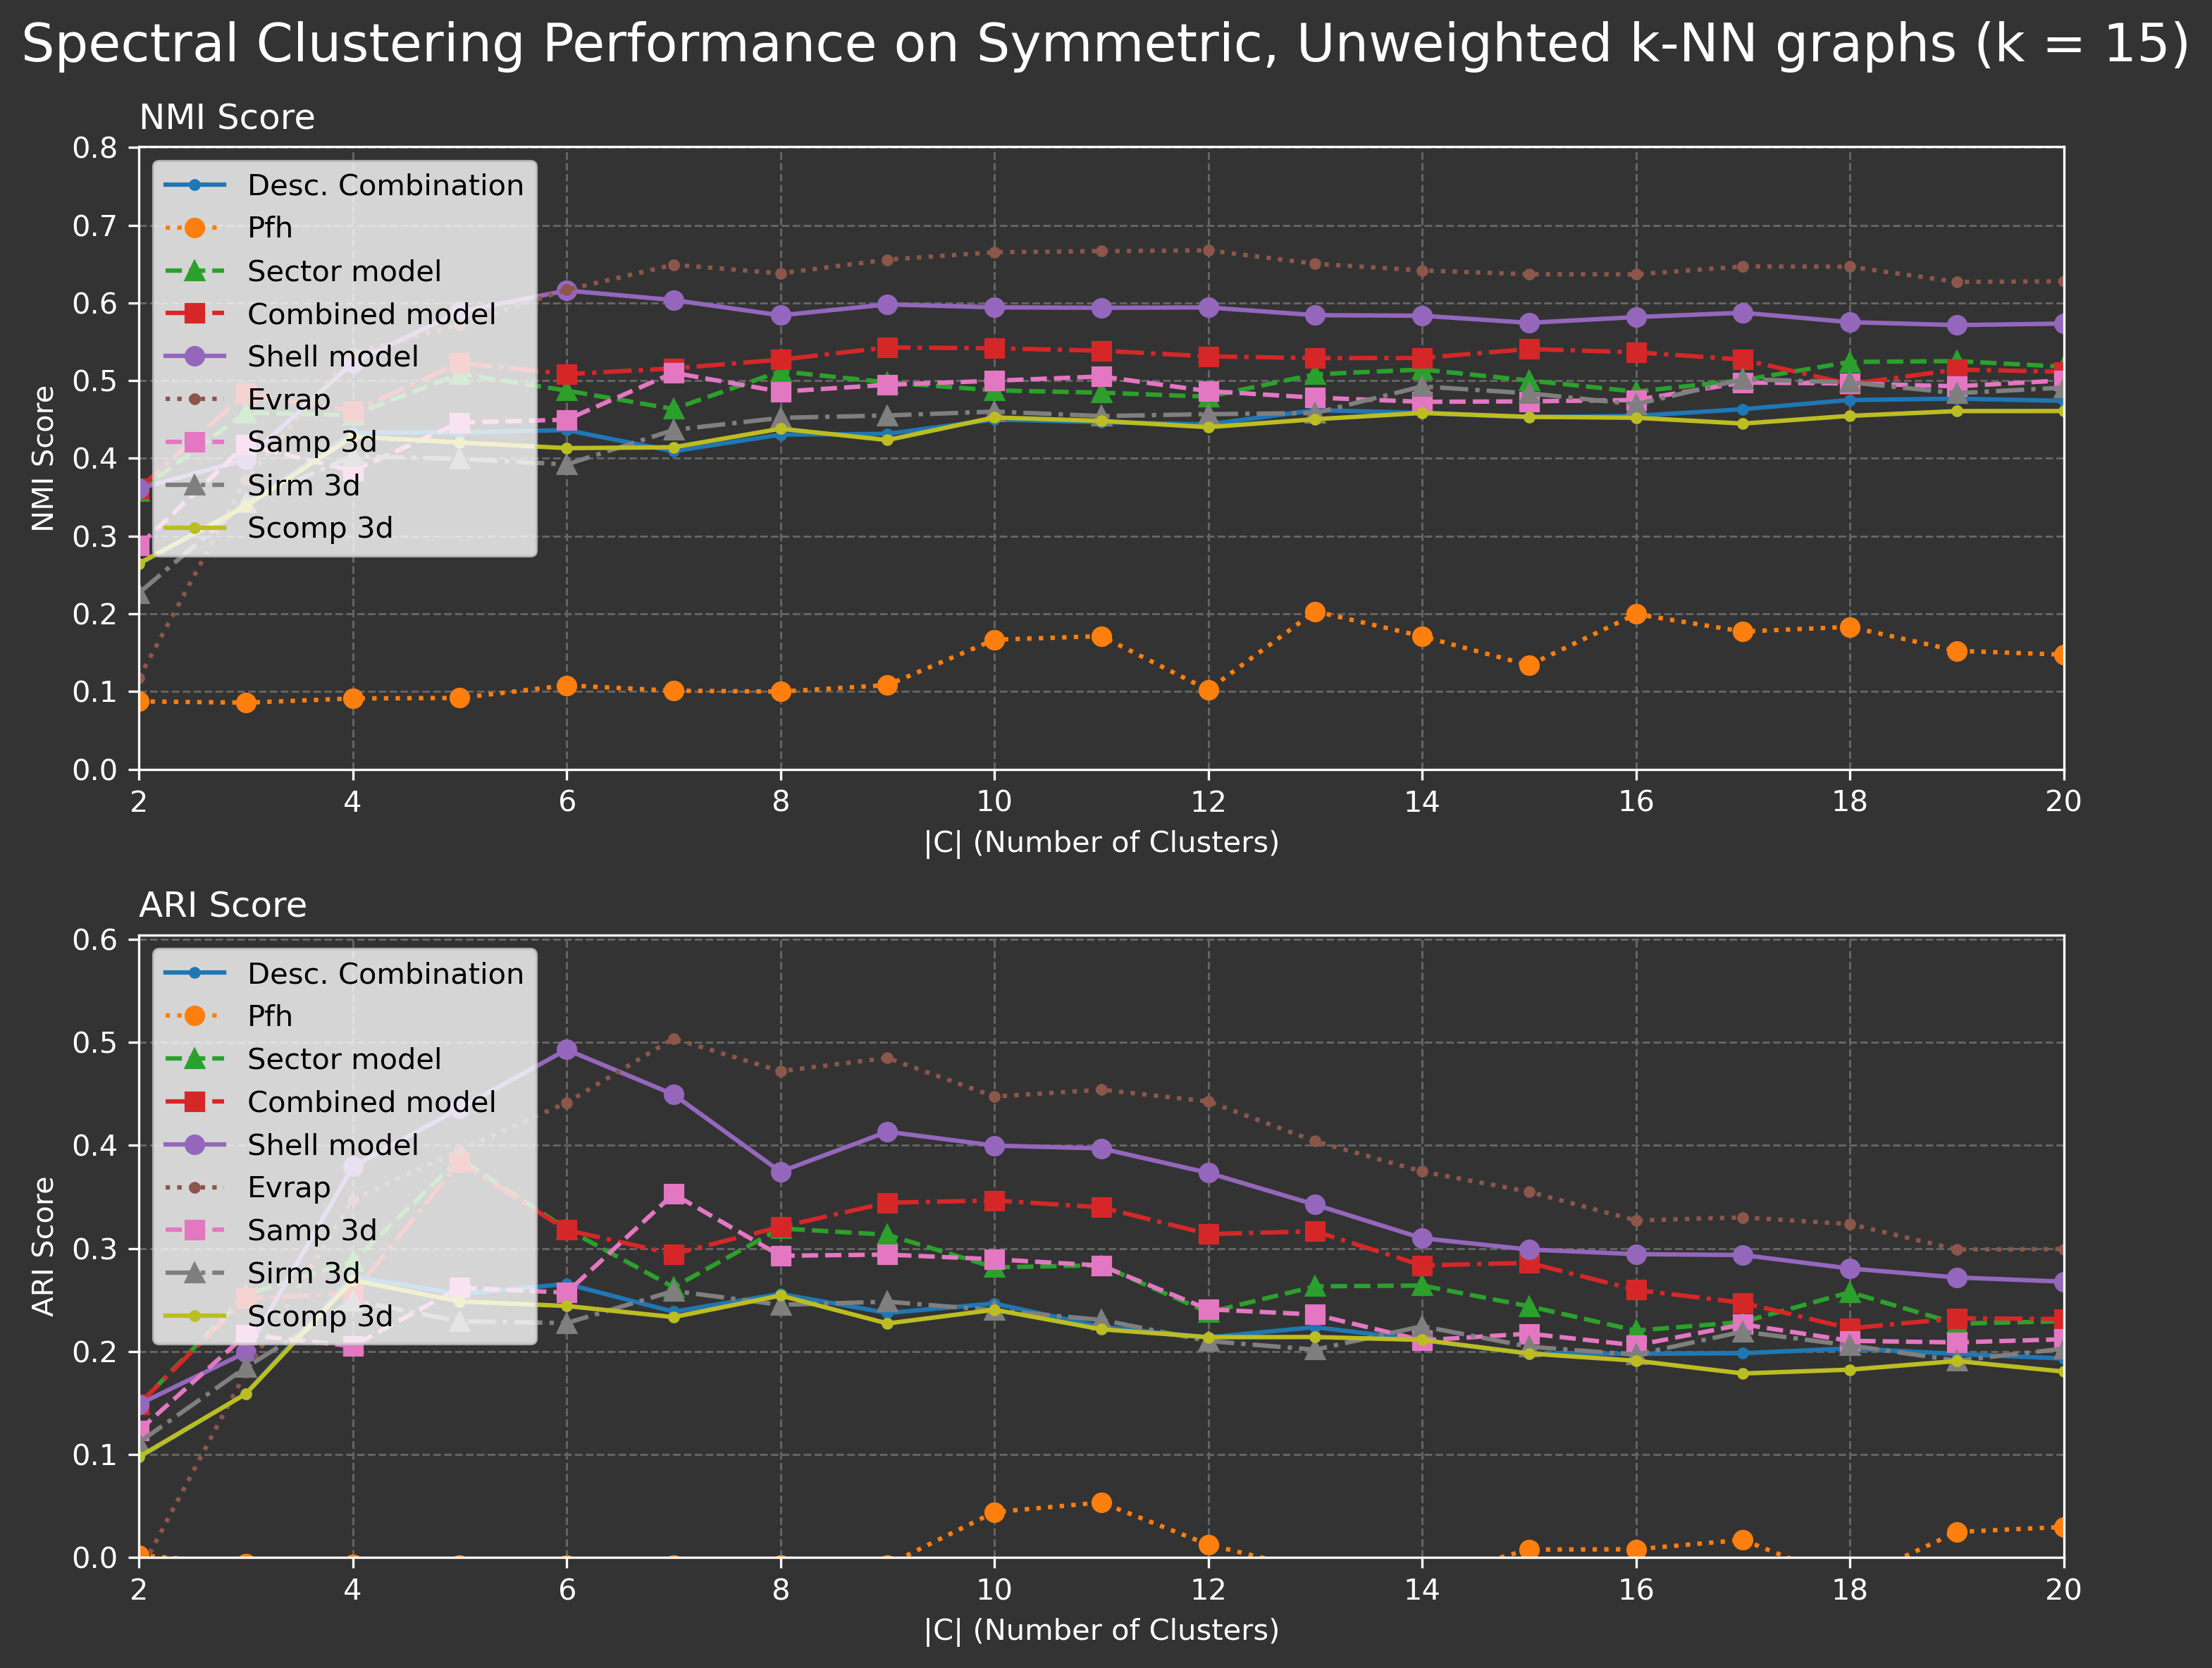

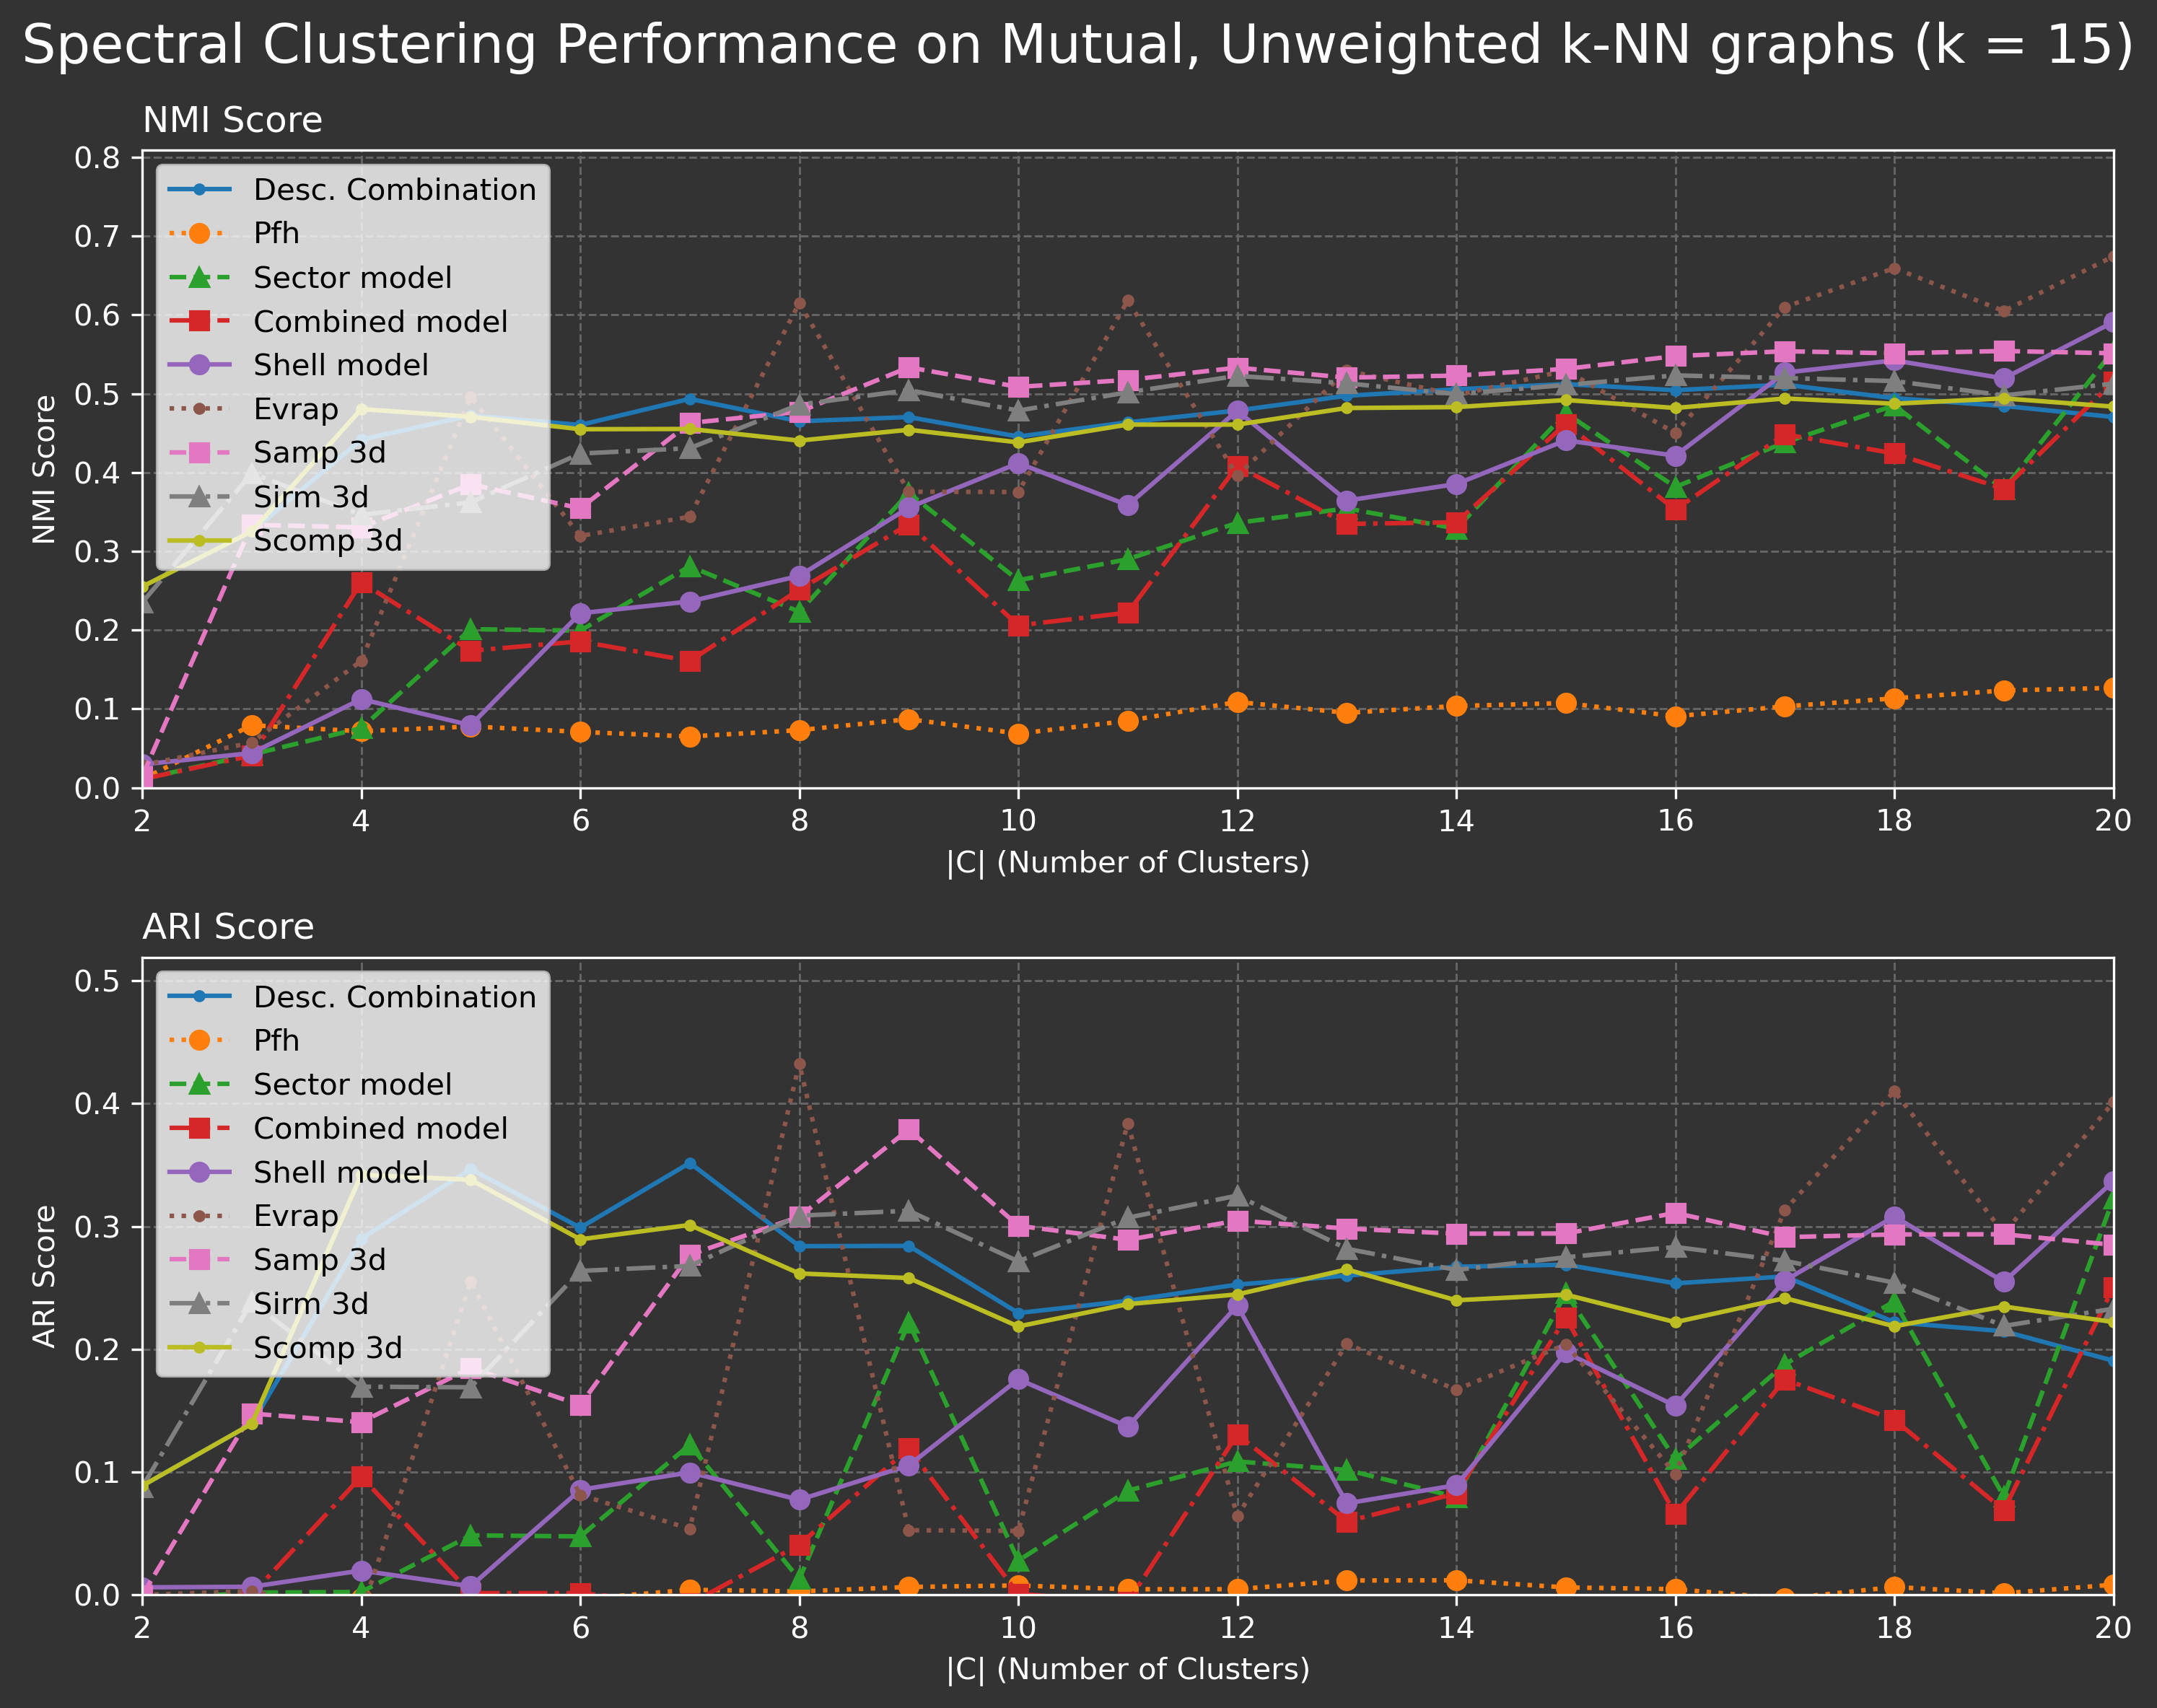

In [4]:
knn_k = [5, 15]
knn_modes = ['distance', 'connectivity']
for k in knn_k:
    for knn_mode in knn_modes:
        weighted = ''
        if knn_mode == 'distance':
            weighted = 'weighted'
        else:
            weighted = 'unweighted'

        plot_data_nmi_ari = load_or_compute_data(knn_mode, k)

        for graph_type in knn_types:
            fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=300)  # Example with a 2x2 grid of subplots
        
            plot_evaluation(axes[0], descriptors, plot_data_nmi_ari[graph_type]['nmi'], plot_data_nmi_ari['cluster_size'],
                            x_label='|C| (Number of Clusters)', y_label='NMI Score',
                            title='NMI Score')
        
            plot_evaluation(axes[1], descriptors, plot_data_nmi_ari[graph_type]['ari'], plot_data_nmi_ari['cluster_size'],
                            x_label='|C| (Number of Clusters)', y_label='ARI Score',
                            title='ARI Score')
        
            fig.suptitle(
                f"Spectral Clustering Performance on {graph_type.capitalize()}, {weighted.capitalize()} k-NN graphs (k = {k})",
                color="white", fontsize=18, x=0.01, horizontalalignment="left")
        
            fig.patch.set_facecolor('#333333')
            fig.tight_layout()
        
            plt.savefig(f"figures/{file}/nmi_ari/{weighted}_{graph_type}_knn_nmi_ari_k{k}.png")
            plt.show()